In [96]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

# animations, etc. requires below magic command
# %matplotlib notebook


"""
Load relevant packages
"""

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation, cm

from scipy import stats
from scipy import optimize
from scipy.optimize import minimize
from functools import reduce


import autograd
from statsmodels.tools.numdiff import approx_fprime, approx_hess

from typing import Union, List

"""
Own packages
"""

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction to fixed income modelling 

__Note__: For further details the reader is referred to [Claus Munk (2013), "Fixed income modelling"](https://www.amazon.co.uk/Fixed-Income-Modelling-Claus-Munk/dp/0198716443)

The term [_fixed income_](https://www.investopedia.com/terms/f/fixedincome.asp) refers to assets and securities that pay out a set level of cash flows to investors, typically in the form of fixed interest or dividends. The simplest fixed income instruments are bonds that we can think of as a tradable loan agreement. 

We will in this lecture note introduce some terminology and see how we can extract yield curves from observed bond prices. The yield captures the infomation we need to price of fixed income instruments.   

## Some terminology 

### Bond types

__Zero-coupon bond - the fundamental building-block__

A zero coupon bond is the simplest type of bond. A coupon bond at time $t$ promises a single payment (we assume 1 if not otherwise stated) at time $T \geq t$ and has the price $B_t^T$. Note that $B_t^t = 1$. The zero coupon bond represents the market discount factor for a sure time $T$ payment. 

__Coupon bonds__

A _coupon bond_ has multiple payments $Y_i, \; i = 1, ...,n$ for different payments dates $T_i = T_1, ..., T_n$. We can think of a coupon bond as a portfolio of zero coupon bonds. Thus, if we can obtain the zero coupon term structure, we can price any coupon bond (or fixed cash flow). The price of a bond can be written as

$$
B_t = \sum_{T_i > t} Y_i B_t^{T_i}
$$

Typically, coupon bonds have fixed payment intervals, e.g. $\delta \in  [0.25, 0.5, 1.0]$ corresponding to quarterly, semi-annually, and yearly. The size of payments is determined by the face value, coupon rate and amortization principle.  The coupon rate $R$ is typically qouted annually such that the periodic coupon rate is $\delta R$. 

Three examples of coupon bonds are

* Bullet bonds
* Annuity bonds
* Serial bonds

_Bullet bonds_ pays the periodic coupon rate times the face value for all payment dates expect for the last payment where the face value also is repaid. E.g a 5-year bullet bond with coupon rate $R$ and face value of $1$: 

$$
Y_i = \left \{ \begin{array}{ll} R, & i = 1, ..., 4\\ 1 + R, & i=5 \end{array} \right. 
$$

_Annuity bonds_ have equal payments for all payments dates. Each payment is composed of an interest payment and a principle repayment. A $n$-year annuity with annual payments will have the payments

$$
Y_i = Y = \frac{R}{1 - (1+R)^{-n}}
$$

_Serial bonds_ pays the face value back in equal installments. A $n$ year bond with annual payments 

$$
Y_i = \frac{1}{n} + R(1 - \frac{i-1}{n})
$$


### Yields and zero-coupon rates

The _yield_ of a bond, $\hat{y}_t^B$ (annually compounded) or $y_t^B$ (continuous compounding),  is the discount rate for which the present value of the future payments discounted at that rate is equal to the current price of the bond. The annually compuounded yield

$$
B_t = \sum_{T_i > t} Y_i \left(1 +  \hat{y}_t^B\right)^{-(T_i - t)}
$$

and the continuous compounded yield 

$$
B_t = \sum_{T_i > t} Y_i e^{-y_t^B (T_i - t)}
$$


We will often be interested in the zero-coupon yields that convey the same information as the discounter factor and thereby usefull for pricing other fixed income sercurites. Again, the _annually compounded_ zero-coupon yield is 
$$
B_t^T =  \left(1 +  \hat{y}_t^T\right)^{-(T - t)}
$$
Solving for the yield gives us 

$$
\hat{y}_t^T = \left(B_t^T \right)^{- \frac{1}{T-t}} - 1
$$

For the case with _continuous compounding_ we have 
$$
B_t^T = e^{-y_t^T (T - t)}
$$
and the corresponding zero-coupon yield 
$$
y_t^T = - \frac{1}{T-t}\ln B_t^T
$$

Our goal will be to find a zero-coupon yield curve such that we can price a range of fixed income instruments. 

### Forward rates

The _forward rate_ reflects the price on a loan between two future dates. The _annually compounded_ forward rate between time $T$ and $S$ is given by 

$$
\hat{f}_t^{T,S} = \left(\frac{B_t^T}{B_t^S} \right)^{1/(S-T)} - 1
$$
such that 
$$
\left(1 +  \hat{y}_t^S\right)^{-(S-t)} = \left(1 + \hat{y}_t^T \right)^{-(T-t)} \left(1 + \hat{f}_t^{T,S}  \right)^{-(S-T)}
$$
Similarly, with _continuous compounding_ we have 
$$
f_t^{T,S} = - \frac{\ln B_t^S - \ln B_t^T}{S-T}
$$
such that 
$$
B_t^S = B_t^T e^{-f_t^{T,S}(S-T)}
$$
We obtain the instantaneous forward rate as the limit when $S \to T$
$$
f_t^T = \frac{\partial \ln B_t^T}{\partial T} = - \frac{\partial B_t^T}{\partial T} \frac{1}{B_t^T}
$$
The zero-coupon yield is related to the instantaneous forward rates as follows
$$
y_t^T = \frac{1}{T-t}\intop_t^T f_t^u du
$$
such that 
$$
B_t^T = e^{-\intop_t^T f_t^u du}
$$

## Extracting yield curves from bond prices


### Bootstrapping

Boostrapping is the simplest way of obtaining zero-coupon yields. If we observe coupon bonds then we will be able to back-out the implicit zero-coupon yields consistent witht the observed market prices. Assume that we have the two bonds and we are standing at time $t=0$

|| Cash Flow, $t=1$| Cash Flow, $t=2$| Price  |
|:----------|||----------|
| Bond 1    | 110|   | 100.0  |
| Bond 2    |5 | 105    | 90.0  |


Then clearly, the discount factor (the price of a zero-coupon bond) maturing at time $t=1$ is 
$$
100 = 110 B_0^1 \Rightarrow B_0^1 = \frac{1}{110} 100 
$$
and 
$$
90 = 5 B_0^1 + 105 B_0^2 = 5 \frac{1}{110} 100 + 105 B_0^2  \Rightarrow B_0^2 = \frac{1}{105} 90 +  \frac{5}{105}  \frac{1}{110} 100
$$

In [71]:
cf_matrix = np.array([[110.0, 0.0],
                      [5.0, 105.0]])
price_vector = np.array([100.0, 90.0])

# discount factors
discount_factors = np.linalg.inv(cf_matrix)@price_vector
discount_factors

array([0.90909091, 0.81385281])

In [72]:
# zero yields
zero_yields = -np.log(discount_factors)/np.array([1.0, 2.0])
zero_yields

array([0.09531018, 0.10298787])

The example above shows us that we basically need to solve a system of equations 
$$
\mathbf{B}_t = \begin{bmatrix} B_{1,t} \\ B_{2, t} \\  \vdots \\ B_{M, t} \end{bmatrix}  = 
\begin{bmatrix} Y_{1,1} & Y_{1,2} & \dots & Y_{1, N} \\ 
Y_{2, 1} & Y_{2,2} & \dots & Y_{2, n}\\  
\vdots & \vdots & \ddots & \vdots \\
Y_{M, 1} & Y_{M, 2} & \dots & Y_{M, M}  \end{bmatrix} 
\begin{bmatrix} B_{t}^{T_1} \\ B_t^{T_2} \\  \vdots \\ B_t^{T_N} \end{bmatrix} = \mathbf{C}_t  \mathbf{Z}_t
$$
where we have $M$ different bonds with $n$ different payment dates - note that some payments may be zero. Given the cash flows and observed bond prices, we can solve of a unique discount vector $\mathbf{Z}_t$
$$
Z_t = \mathbf{C}^{-1} \mathbf{B}_t
$$
if the cash flow matrix $\mathbf{C}_t$ is invertible (non-singular). If $M>N$ the system of equation may not have any solutions and if $m<n$ then we may have multiple solutions. 


__Example__

__Note__: Example is adapted from _Exercise 2.2_ in [Claus Munk (2013), "Fixed income modelling"](https://www.amazon.co.uk/Fixed-Income-Modelling-Claus-Munk/dp/0198716443)

Consider a bond market in which 10 bullet bonds are traded. They all have face value of 100, a coupon rate of 5\%, annual payments and exactly one year to the next payment. The bonds mature in 1, 2, ...,  10 years:

| Maturity  |  Price   |
|:----------|----------|
| 1         | 101.942  |
| 2         | 103.290  |
| 3         | 104.118  |
| 4         | 104.460  |
| 5         | 104.355  |
| 6         | 104.256  |
| 7         | 104.552  |
| 8         | 105.210  |
| 9         | 105.482  |
| 10        | 105.399  |


Perform the following calculations: 

* Find the discount factors
* Find the corresponding zero yields (qouted annually)

In [73]:
"""
Define price vector 
"""

prices = np.array([101.942, 103.290, 104.118, 104.460, 104.355,
                   104.256, 104.552, 105.210, 105.482, 105.399])

"""
Create relevant cash flow matrix
"""

maturities = np.arange(1.0, 11.0, 1.0)

term_info = list()
flow_info = list()
for maturity in maturities: 
    
    terms = np.arange(1.0, maturity + 1.0, 1.0)
    flows = np.ones_like(terms) * 5 
    flows[-1] += 100
    
    term_info.append(terms)
    flow_info.append(flows)

all_terms = reduce(np.union1d, term_info)

cash_flow_matrix = np.zeros((maturities.shape[0] , all_terms.shape[0]))

idx = 0
for terms, flows in zip(term_info, flow_info):
    
    indicator = np.in1d(all_terms, terms)

    cash_flow_matrix[idx, indicator] = flows
    
    idx += 1

In [74]:
cash_flow_matrix

array([[105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5., 105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5., 105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5., 105.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5., 105.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5., 105.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5., 105.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5., 105.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5., 105.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5., 105.]])

In [75]:
"""
Calculate discount factors 
"""

discount_factors = np.linalg.inv(cash_flow_matrix) @ prices
discount_factors

array([0.97087619, 0.93748209, 0.9007258 , 0.86109123, 0.81908689,
       0.7791399 , 0.74485704, 0.71565433, 0.68416603, 0.65079621])

In [76]:
cash_flow_matrix @ discount_factors

array([101.942, 103.29 , 104.118, 104.46 , 104.355, 104.256, 104.552,
       105.21 , 105.482, 105.399])

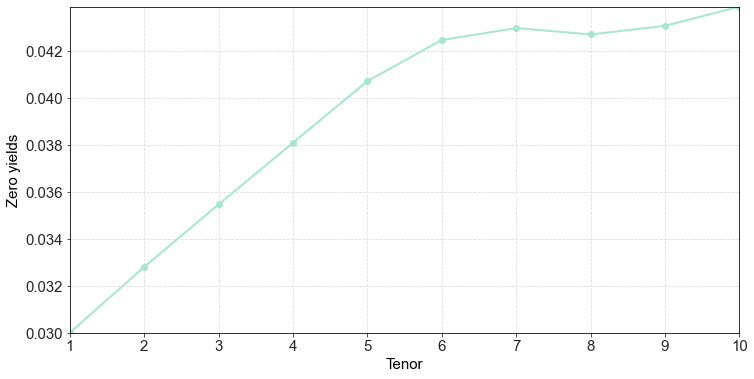

In [77]:
"""
Calculate zero yields
"""

zero_yields_boot = discount_factors**(-1 / maturities) - 1

fig, ax = plt.subplots(figsize=(12,6)) 
plt.plot(maturities, zero_yields_boot, marker='o');
plt.xlabel('Tenor');
plt.ylabel('Zero yields');

Assume now that we drop the bond with maturity in 5 years. Will it still be possible to use the above procedure? 

In [10]:
"""
Define price vector 
"""

prices = np.array([101.942, 103.290, 104.118, 104.460,
                   104.256, 104.552, 105.210, 105.482, 105.399])

"""
Create relevant cash flow matrix
"""

maturities = np.concatenate((np.arange(1.0, 5.0, 1.0), np.arange(6.0, 11.0, 1.0)))

term_info = list()
flow_info = list()
for maturity in maturities: 
    
    terms = np.arange(1.0, maturity + 1.0, 1.0)
    flows = np.ones_like(terms) * 5 
    flows[-1] += 100
    
    term_info.append(terms)
    flow_info.append(flows)

all_terms = reduce(np.union1d, term_info)

cash_flow_matrix = np.zeros((maturities.shape[0] , all_terms.shape[0]))

idx = 0
for terms, flows in zip(term_info, flow_info):
    
    indicator = np.in1d(all_terms, terms)

    cash_flow_matrix[idx, indicator] = flows
    
    idx += 1

In [11]:
cash_flow_matrix

array([[105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5., 105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5., 105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5., 105.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5., 105.,   0.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5., 105.,   0.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5., 105.,   0.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5., 105.,   0.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5., 105.]])

In [12]:
cash_flow_matrix.shape

(9, 10)

In [13]:
#  the rank cannot be larger than the num. of cols or rows
np.linalg.matrix_rank(cash_flow_matrix)

9

NO, the cash flow matrix is no longer invertible and we cannot apply the above methodology! We will get an error if we try to evaluate the code `np.linalg.inv(cash_flow_matrix)`. 

### Alternatives to bootstrapping: Splines

Bootstrapping can only give us the discount factors for the payment dates, but it may be valuable to know the discount factors for any given day in the future. There is a large literature on how to estimate the entire term structure of interest rates, think of it as a function $T \to B_t^T$, up to some large $T$. To simplify notation we will define 

$$
B(\tau) = B_t^{t + \tau}, \; \; \tau \in [0, \infty)
$$

representing the time $t$ discount function. The objective is to specify some function form for $B(\tau)$ such that we get as close as possible to observed bond prices. 

The first example we will look at involves representing the discount function using splines. [Claus Munk (2013), "Fixed income modelling"](https://www.amazon.co.uk/Fixed-Income-Modelling-Claus-Munk/dp/0198716443) presents a method inspired by [McCulloch (1975)](https://www.jstor.org/stable/2326860), among others. 

The basic idea is to divide the time to maturity into $k$ subintervals $0 = \tau_0 < \tau_1 < \dots < \tau_k$ and define the discount function as 

$$
B(\tau) = \sum_{j=1}^{k-1} G_j(\tau)I_j(\tau)
$$
where $G_j(\cdot)$ are the basis functions and $I_j(\cdot)$ is a step function 

$$
I_j(\tau) = \left \{ \begin{array}{ll} 1, & \tau \geq \tau_j \\ 0, & \text{otherwise.}\end{array} \right.
$$

To ensure nice properties of the discount function, we will require the basis functions being continuous and differentiable. One example is the cubic spline where the basis functions are specified as third degree polynomials

$$
G_j(\tau) = \alpha_j + \beta_j (\tau - \tau_j) + \gamma_j (\tau - \tau_j)^2 + \delta_j (\tau - \tau_j)^3
$$

where $\alpha_j , \beta_j , \gamma_j , \delta_j$ are constants. 

To obtain a reasonable discount function, we need to impose a number of constraints on the cubic splines, e.g. for $\tau < \tau_1$ we have

$$
B(\tau) = \alpha_0 + \beta_0 \tau + \gamma_0\tau^2 + \delta_0 \tau^3
$$

enuring $B(0) =1$ requires $\alpha_0 = 1$. After imposing all constraints, we will have

$$
B(\tau) = 1 + \beta_0 \tau + \gamma_0\tau^2 + \delta_0 \tau^3 + \sum_{j=1}^{k-1} \delta_j (\tau - \tau_j)^3 I_j(\tau)
$$

Given this specification of the discount function, we need to choose the parameters such discounting known bond cash flows gets as close as possible to their observed market prices. If we let $t_n$ denote the time distance from today (time $t$) to the $n$'th payment date we would obtain 

$$
B_i = \sum_{n=1}^N Y_{in} B(t_n) + \varepsilon_i
$$

where $\varepsilon_i$ is the pricing error for bond $i$. Since we have specified the functional form for $B(\tau)$, we can write 

$$
B_i = \sum_{n=1}^N Y_{in} \left[1 + \beta_0 t_n + \gamma_0 t_n^2 + \delta_0 t_n^3 + \sum_{j=1}^{k-1} \delta_j (t_n - \tau_j)^3 I_j(\tau)\right] + \varepsilon_i
$$

which also implies

$$
B_i  - \sum_{n=1}^N Y_{in} = \beta_0 \sum_{n=1}^N Y_{in}  t_n + \gamma_0 \sum_{n=1}^N Y_{in}  t_n^2 + \delta_0 \sum_{n=1}^N Y_{in}  t_n^3 + \sum_{j=1}^{k-1} \sum_{n=1}^N Y_{in}  \delta_j (t_n - \tau_j)^3 I_j(\tau) + \varepsilon_i
$$

Given $M$ bonds, we can simply estimate the model using OLS. Before estimating the discount function, we need to choose the number of subintervals $k$ (number of knot points).  McCulloch(1975) suggests to set $k$ equal to the nearest integer to $\sqrt{M}$  and define

$$
\tau_j = T_{h_j} + \theta_j (T_{h_j} - T_{h_j})
$$

where $h_j = \lfloor j \cdot M / k\rfloor $ (the integer part) and $\theta_j = j \cdot M / k - h_j$. Alternative one can choose reasonable values that span the the curve. 

There are some problems with the cubic spline methodology:

* May violate the no-arbitrage principle
* The resulting curve may not have an economically credible form (positive forward rates)
* May be very sensitive to the location of the knot points
* Small changes in input bond prices may have a large effect on the results

__Example:__

Below we will implement the cubic spline methodology to the same example used above. 

First, we define the relevant functions to perform the calculation. 

In [107]:
def cubic_spline_discount_factor(tenor: Union[float, np.ndarray], params: np.ndarray, tau_values: np.ndarray):
    
    """
    Calculates the discount factors for the Cubic Spline methodology
    
    Parameters
    ----------
    
    tenor:
        Tenor for which to get the discount factor.
    params: 
        Parameters for the cubic spline.
    tau_values: 
        The knot points of the cubic spline. 
        
    Return
    ------
    Union[float, np.ndarray]
        The discount factor. 
    
    """
    
    # ensure that the tenor is at least 1-d 
    tenor = np.atleast_1d(tenor)
    
    # create the "tau matrix" consisting of tenor - tau_j 
    tau_matrix = tenor[:, None]  - tau_values[None, :]
    
    # apply the discount factor formula
    zcb = (1 + params[0] * tenor + params[1] * tenor**2 + params[2] * tenor**3 +
           (tau_matrix**3 * (tau_matrix >= 0)) @ params[3:])

    return zcb

def cubic_spline_zero_yield(tenor, params, tau_values, discrete=True):
    
    """
    Calculates the zero yield for the Cubic Spline methodology
    
    Parameters
    ----------
    
    tenor:
        Tenor for which to get the zero yield factor.
    params: 
        Parameters for the cubic spline.
    tau_values: 
        The knot points of the cubic spline. 
        
    Return
    ------
    Union[float, np.ndarray]
        The zero yield. 
    
    """
    # calculate discount factors
    zcb = cubic_spline_discount_factor(tenor, params, tau_values)
    # apply the relationship between discount factor and zero yield
    if discrete:
        y = zcb**(-1 / tenor) - 1
    else:
        y = -np.log(zcb) / tenor
        
    return y


def estimate_cubic_spline(payment_dates: np.ndarray, cash_flow_matrix: np.ndarray,
                          market_prices: np.ndarray, tau_values: np.ndarray): 
    
    """
    Estimate parameters for the cubic spline curve. 
    
    Parameters
    ----------
    
    payment_dates:
        All cash flow payment dates.
    cash_flow_matrix: 
        Cash flow matrix [number bonds x number payment dates].
    market_prices:
        Bond market prices. 
    tau_values: 
        The knot points of the cubic spline. 
        
    Return
    ------
    Union[float, np.ndarray]
        The zero yield. 
    
    """
    
    # step 1: create independent variables
    tau_matrix = payment_dates[:, None]  - tau_values[None, :]
    tau_matrix = tau_matrix**3 * (tau_matrix >= 0)
    
    x_mat = np.c_[(cash_flow_matrix @ payment_dates,
                   cash_flow_matrix @ payment_dates**2,
                   cash_flow_matrix @ payment_dates**3,
                   cash_flow_matrix @ tau_matrix)]
    
    # step 2: create dependent variable
    y_vec = market_prices - np.sum(cash_flow_matrix, axis=1)
    
    # step 3: performe OLS regression 
    params = np.linalg.lstsq(x_mat, y_vec, rcond=False)[0]
    
    return params  

In [108]:
"""
Just redefine price vector and cash flow matrix from first example
"""


"""
Define price vector 
"""

prices = np.array([101.942, 103.290, 104.118, 104.460, 104.355,
                   104.256, 104.552, 105.210, 105.482, 105.399])

"""
Create relevant cash flow matrix
"""

maturities = np.arange(1.0, 11.0, 1.0)

term_info = list()
flow_info = list()
for maturity in maturities: 
    
    terms = np.arange(1.0, maturity + 1.0, 1.0)
    flows = np.ones_like(terms) * 5 
    flows[-1] += 100
    
    term_info.append(terms)
    flow_info.append(flows)

all_terms = reduce(np.union1d, term_info)

cash_flow_matrix = np.zeros((maturities.shape[0] , all_terms.shape[0]))

idx = 0
for terms, flows in zip(term_info, flow_info):
    
    indicator = np.in1d(all_terms, terms)

    cash_flow_matrix[idx, indicator] = flows
    
    idx += 1

In [203]:
# estimate parametes
params = estimate_cubic_spline(all_terms, cash_flow_matrix, prices, np.array([1.0, 5.0, 7.0]))

In [218]:
tenors_to_plot = np.linspace(1.0, 10.0, 50)

# calculate discount factors and zero yields
discount_factors_cubic = cubic_spline_discount_factor(tenors_to_plot, params, np.array([1.0, 5.0, 7.0]))
zero_yields_cubic = cubic_spline_zero_yield(tenors_to_plot, params, np.array([1.0, 5.0, 7.0]))

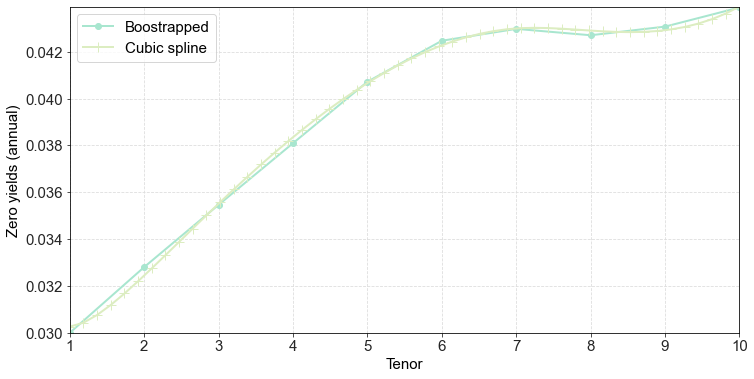

In [205]:
fig, ax = plt.subplots(figsize=(12,6)) 
ax.plot(maturities, zero_yields_boot, marker='o', label="Boostrapped");
ax.plot(tenors_to_plot, zero_yields_cubic, marker='+', markersize=10, label="Cubic spline");
ax.set_xlabel('Tenor');
ax.set_ylabel('Zero yields (annual)');
ax.legend()

### Alternatives to bootstrapping: Nelson-Siegel Svennson 

__Note:__ The notation differ somewhat from the exercises in week 5. 


[Nelson and Siegel (1987)](https://www.jstor.org/stable/2352957) proposed a often used parameterization of the term structure of interest. They specified the following parameterization of the instantaneous forward rate

$$
f(\tau) = \beta_0 + \beta_1 e^{-\tau / \theta} + \beta_2 \frac{\tau}{\theta} e^{-\tau / \theta} 
$$

From newly gained knowledge, we know that the continuous zero coupon yield can be written as

$$
y(\tau) = \frac{1}{\tau} \intop_{0}^\tau f(u)  du = \beta_0 + \beta_1 \frac{1 - e^{-\tau / \theta}}{\tau / \theta} + \beta_2 \left(\frac{1 - e^{-\tau / \theta}}{\tau / \theta} - e^{-\tau / \theta} \right)
$$

The interpretation of the different terms in the above expression for the zero yields is intuitive. We can think of the parametes $\beta_0$, $\beta_1$ and $\beta_2$ as the relative weight of three factors. The first factor is the level factor (just equal to one) which affects all tenors (maturities) in the same way. The second factor is the slope factor mostly affecting short maturites. The third factor is the curvature factor primarily affecting intermediate tenors. 

In [206]:
# define  slope and curveture factor 
def calculate_slope(time_to_maturity: Union[float, np.ndarray], theta: float): 
    
    return (1 - np.exp(-time_to_maturity / theta)) / (time_to_maturity / theta)

def calculate_curvature(time_to_maturity: Union[float, np.ndarray], theta: float): 
    
    return (1 - np.exp(-time_to_maturity / theta)) / (time_to_maturity / theta) - np.exp(-(time_to_maturity / theta))

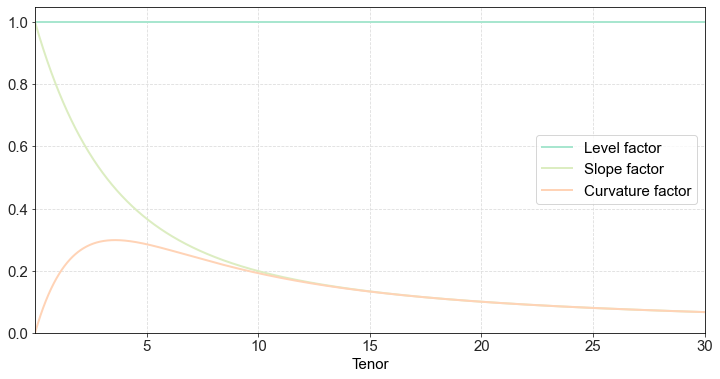

In [207]:
time_to_maturities = np.linspace(0.0001, 30.0, 1000)
theta = 2.0

level_factors = np.ones_like(time_to_maturities)
slope_factors = calculate_slope(time_to_maturities, theta)
curvature_factors = calculate_curvature(time_to_maturities, theta)

"""
Plotting 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_to_maturities, level_factors, label="Level factor")
ax.plot(time_to_maturities, slope_factors, label="Slope factor")
ax.plot(time_to_maturities, curvature_factors, label="Curvature factor")
ax.set_xlabel('Tenor')
ax.set_ylim([0.0, 1.05])
ax.legend();

We can write the discount function as

$$
B(\tau) = e^{ - \tau \cdot y(\tau)} = \exp \left[ - \tau\beta_0 - \beta_1 \frac{1 - e^{-\tau / \theta}}{1 / \theta} -  \beta_2 \left(\frac{1 - e^{-\tau / \theta}}{1 / \theta} - \tau e^{-\tau / \theta} \right) \right]
$$

Again, we can write 

$$
B_i = \sum_{n=1}^N \exp \left[ - \tau\beta_0 - \beta_1 \theta (1 - e^{-\tau / \theta}) -  \beta_2 \left(\theta (1 - e^{-\tau / \theta}) - \tau e^{-\tau / \theta} \right) \right] + \varepsilon_i
$$

since this is a non-linear expression, we need to use non-linear least squares when estimating the parameters. 

__Example__

Estimate the parameters of a Nelson-Siegel curve using the same data as in the previous examples. 

First, we define relevant functions. 

In [237]:
def nelson_siegel_discount_factor(tenor: Union[float, np.ndarray], params):
    
    beta0 = params[0]
    beta1 = params[1]
    beta2 = params[2]
    theta = params[3]
    
    level = np.ones_like(tenor)
    slope = calculate_slope(tenor, theta)
    curvature = calculate_curvature(tenor, theta)
    
    return np.exp(-tenor * (beta0 * level + beta1 * slope + beta2 * curvature))

def nelson_siegel_zero_yield(tenor: Union[float, np.ndarray], params):
    
    beta0 = params[0]
    beta1 = params[1]
    beta2 = params[2]
    theta = params[3]
    
    level = np.ones_like(tenor)
    slope = calculate_slope(tenor, theta)
    curvature = calculate_curvature(tenor, theta)
    
    return beta0 * level + beta1 * slope + beta2 * curvature


def nelson_siegel_objective(params: np.ndarray,
                            payment_dates: np.ndarray,
                            cash_flow_matrix: np.ndarray,
                            market_prices: np.ndarray):
    
    return np.sum(np.square(market_prices - cash_flow_matrix @ nelson_siegel_discount_factor(payment_dates, params)))

def nelson_siegel_brute_objective(theta,
                                  payment_dates: np.ndarray,
                                  cash_flow_matrix: np.ndarray,
                                  market_prices: np.ndarray):
    
    x0 = np.array([0.1, 0.1, 0.1, float(theta)])
    
    constraint = {'type': 'eq',
                  'fun' : lambda x: x[-1] - theta}
    
    bounds = [(-1.0, 15.0), (-15.0, 30.0), (-30.0, 30.0), (0, 10.0)]
    
    res = minimize(nelson_siegel_objective, x0=x0, args=(payment_dates, cash_flow_matrix, market_prices),
                   constraints=constraint, bounds=bounds)
    
    return nelson_siegel_objective(res.x, payment_dates, cash_flow_matrix, market_prices)


In [252]:
res = optimize.brute(nelson_siegel_brute_objective, (slice(0.1, 25.0),),
                     args=(all_terms, cash_flow_matrix, prices), Ns=99999)

res

array([4.95805664])

In [257]:
res = minimize(nelson_siegel_objective, x0=[0.01, 0.01, 0.01, 4.8],
               args=(all_terms, cash_flow_matrix, prices))

In [258]:
res.x

array([ 0.02725886, -0.00508586,  0.05918332,  4.98283682])

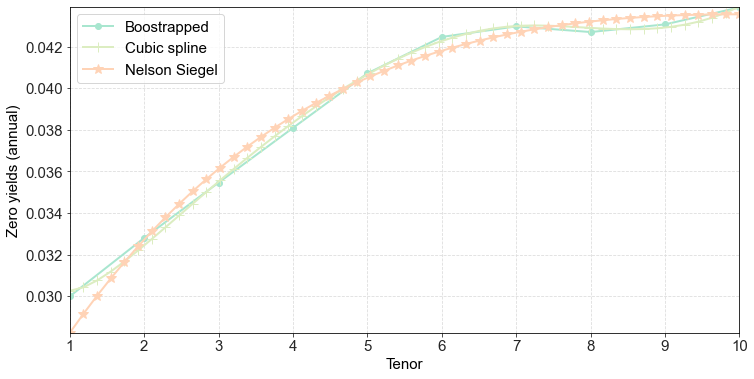

In [241]:
# calculate discount factors and zero yields
discount_factors_ns = nelson_siegel_discount_factor(tenors_to_plot, res.x)
zero_yields_ns = nelson_siegel_zero_yield(tenors_to_plot, res.x)

fig, ax = plt.subplots(figsize=(12,6)) 
ax.plot(maturities, zero_yields_boot, marker='o', label="Boostrapped");
ax.plot(tenors_to_plot, zero_yields_cubic, marker='+', markersize=10, label="Cubic spline");
ax.plot(tenors_to_plot, discount_factors_ns ** (-1 / tenors_to_plot) - 1,
        marker='*', markersize=10, label="Nelson Siegel");
ax.set_xlabel('Tenor');
ax.set_ylabel('Zero yields (annual)');
ax.legend();

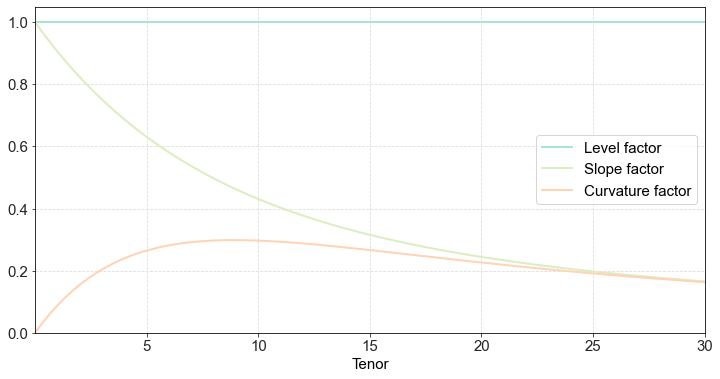

In [236]:
time_to_maturities = np.linspace(0.0001, 30.0, 1000)
theta = res.x[-1]

level_factors = np.ones_like(time_to_maturities)
slope_factors = calculate_slope(time_to_maturities, theta)
curvature_factors = calculate_curvature(time_to_maturities, theta)


"""
Plotting 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_to_maturities, level_factors, label="Level factor")
ax.plot(time_to_maturities, slope_factors, label="Slope factor")
ax.plot(time_to_maturities, curvature_factors, label="Curvature factor")
ax.set_xlabel('Tenor')
ax.set_ylim([0.0, 1.05])
ax.legend();

# References

## Articles

[McCulloch (1975)](https://www.jstor.org/stable/2326860)

[Svensson (1994)](https://www.nber.org/papers/w4871)

[Nelson and Siegel (1987)](https://www.jstor.org/stable/2352957)

## Books

[Claus Munk (2013), "Fixed income modelling"](https://www.amazon.co.uk/Fixed-Income-Modelling-Claus-Munk/dp/0198716443)
